In [21]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## (a) Load dataset

In [2]:
# load data for moviee 100k (all users)
sel_cols = ["user_id", "movie_id", "rating", "unix_timestamp"]
rating_all = pd.read_csv("Data/ml-100k/u.data", sep="\t", names=sel_cols, encoding="latin-1")
# ‘u1.base’ for training and validation
rating_train = pd.read_csv("Data/ml-100k/u1.base", sep="\t", names=sel_cols, encoding="latin-1")
# ‘u1.test’ for testing
rating_test = pd.read_csv("Data/ml-100k/u1.test", sep="\t", names=sel_cols, encoding="latin-1")
print(rating_all.shape)
print(rating_train.shape)
print(rating_test.shape)

(100000, 4)
(80000, 4)
(20000, 4)


In [4]:
# load items file
item_cols = ["movie_id", "movie_title", "release_date", "video_release_data", "IMDB_URL", 
        "unknown", "action", "adventure", "animation", "children's", "comedy", 
        "crime", "documentary", "drama", "fantasy", "film-noir", "horror", "musical", 
        "mystery", "romance", "sci-fi", "thriller", "war", "western"]
items = pd.read_csv("Data/ml-100k/u.item", sep="|", names=item_cols, encoding="latin-1")

## (b) Autoencoder model

In [5]:
class AE_Model(torch.nn.Module):
    def __init__(self, input_dim):
        super(AE_Model, self).__init__()
        # encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512), 
            torch.nn.Linear(512, 256), 
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 32)
        )
        # decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 512),
            torch.nn.Linear(512, input_dim), 
            torch.nn.Sigmoid()
        )
        return 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## (c) Model training and testing 

In [6]:
def user_data(rating, items):
    users_num = rating["user_id"].unique().shape[0]
    movies_num = items.shape[0]
    users = sorted(rating["user_id"].unique())
    user_data = np.zeros((users_num, movies_num)) # 0：a user hasn't watched a movie
    for i, user in enumerate(users):
        movies_watched = rating.loc[rating["user_id"]==user]["movie_id"].unique()-1
        user_data[i, movies_watched] = 1  # 1：a user has watched the movie
    return torch.Tensor(user_data)

In [9]:
data = user_data(rating_train, items)
sample_size = int(len(data)*0.8)
train_data = data[:sample_size].to(device)
val_data = data[sample_size:].to(device)
print("Training data size is {}".format(train_data.shape))
print("Validation data size is {}".format(val_data.shape))

Training data size is torch.Size([754, 1682])
Validation data size is torch.Size([189, 1682])


In [11]:
model = AE_Model(train_data.shape[1]).to(device)
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_loss = []

EPOCHS = 150
for epoch in range(EPOCHS):
    train_data = train_data[torch.randperm(train_data.shape[0])]
    
    optimizer.zero_grad()
    train_predicted = model(train_data)
    loss = loss_function(train_predicted, train_data)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    
    model.eval()
    val_predicted = model(val_data)
    loss = loss_function(val_predicted, val_data)
    val_loss.append(loss.item())
    model.train()
    
_ = model.eval()

The figure of training/validation loss vs epoch


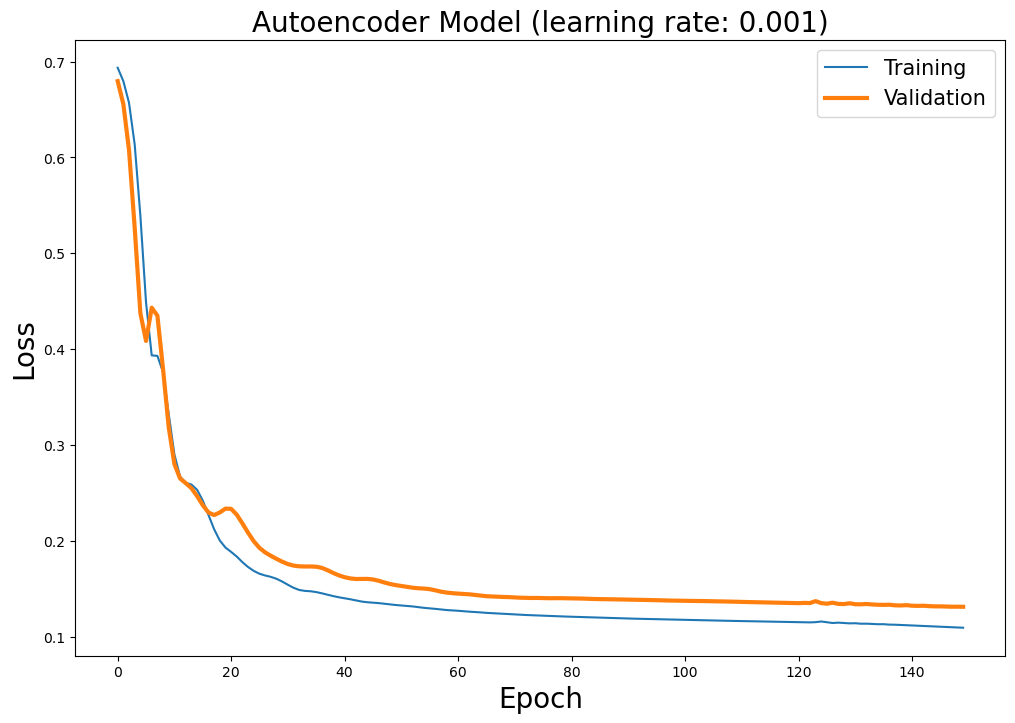

In [16]:
figure = plt.figure(figsize = [12, 8])
plt.plot(np.arange(len(train_loss[:])), train_loss[:], label='Training')
plt.plot(np.arange(len(val_loss[:])), val_loss[:], label='Validation', linewidth=3)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.title("Autoencoder Model (learning rate: 0.001)", fontsize=20)
plt.legend(fontsize=15)
plt.savefig('./autoencoder_model_loss.png')
plt.show() 

### Evaluate the validation and test performance of the model.

In [17]:
test_data = user_data(rating_test, items).to(device)
test_predicted = model(test_data)
test_loss = loss_function(test_predicted, test_data).item()
print("The valiation loss is {:.6}".format(val_loss[149]))
print("The test loss is {:.6}".format(test_loss))

The valiation loss is 0.131388
The test loss is 0.0865686


### Precision and recall for all users

In [18]:
data_all = user_data(rating_all, items)
precision = []
recall = []

for user in range(data_all.shape[0]):
    user_targets = data_all[user].to(device)
    user_predictions = torch.round(model(user_targets))
    user_predictions = user_predictions.cpu().detach().numpy()
    user_targets = user_targets.cpu().detach().numpy()
    precision.append(precision_score(user_targets, user_predictions, zero_division=1))
    recall.append(recall_score(user_targets, user_predictions))

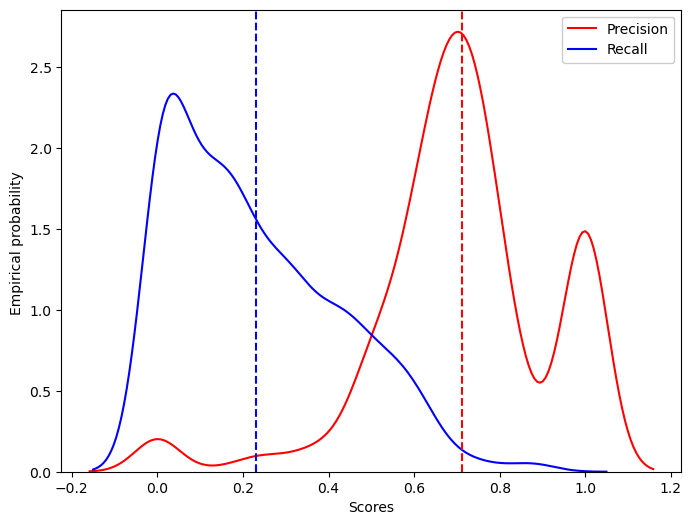

This figure shows the distribution of empirical probability for both precision and recall (dashed line refers to the average score).
The precision average score is 0.7109.
The recall average score is 0.2304.


In [19]:
figure = plt.figure(figsize = [8, 6])
ax = sns.kdeplot(precision, c='r')
ax = sns.kdeplot(recall, ax=ax, c='b')
plt.legend(["Precision", "Recall"], framealpha=1)
plt.axvline(x=np.mean(precision), c='r', ls="--")
plt.axvline(x=np.mean(recall), c='b', ls="--")
plt.ylabel("Empirical probability ")
plt.xlabel("Scores")
plt.show()

print("This figure shows the distribution of empirical probability for both precision and recall (dashed line refers to the average score).")
print("The precision average score is {:.4f}.".format(np.mean(precision)))
print("The recall average score is {:.4f}.".format(np.mean(recall)))

## (d) Recommend the top-10 best NEW movies 

In [20]:
movies_recom = {"User_ID": [], "Rating": [], "Movie_ID": [], }

for user in range(data_all.shape[0]):
    user_targets = data_all[user].to(device)

    user_predictions = model(user_targets).cpu().detach().numpy()
    user_targets = user_targets.cpu().detach().numpy()
    unwatched = np.multiply(user_targets==0, user_predictions) 
    recommended = np.argsort(unwatched)[::-1][:10] 
    user_rating = user_predictions[recommended]

    for r_s, m_id in zip(user_rating, recommended):
        movies_recom["User_ID"].append(user+1) 
        movies_recom["Rating"].append(r_s)
        movies_recom["Movie_ID"].append(m_id+1) 
        
movies_recom = pd.DataFrame(movies_recom)
movies_recom.to_csv("Recommendation Results/pred_movies.txt", index=False)

print("The top-10 best NEW movies recommended to the first user:")
movies_recom.head(10)

The top-10 best NEW movies recommended to the first user:


,User_ID,Rating,Movie_ID
0,1,0.787560,405
1,1,0.777752,423
2,1,0.694326,385
3,1,0.679585,568
4,1,0.653178,367
5,1,0.630022,655
6,1,0.626978,318
7,1,0.624968,546
8,1,0.613812,288
9,1,0.611524,403
